# Comparing Gaussian noise on Re/Im to random uniform phases

See https://empymod.emsig.xyz/en/latest/gallery/educational/random_noise_f_domain.html

Adding random noise to frequency-domain CSEM data is not a trivial task, and there are many different ways how it is done. The problem comes from the fact that we live in the time-domain, our noise is time-domain noise, but we have to add complex-valued frequency-domain noise.


Let's assume we have complex-valued data $d$. We can add random noise to the data in the following way,

$$
    \tilde{d} = d + \sigma \left[(1 + \text{i})\,\mu + \mathcal{R} \right] \, .
$$

where $\sigma$ is the standard deviation, $\mu$ is the mean value of the randomly distributed noise, and $\mathcal{R}$ is the random noise. We define the standard deviation as,

$$
    \sigma = \sqrt{\epsilon_\text{n}^2 + \left(\epsilon_\text{r}|d|\right)^2 } \, ,
$$

where $\epsilon_\text{n}$ is the noise floor and $\epsilon_\text{r}$ is the relative error.


We compare three ways of computing the random noise $\mathcal{R}$. See at the bottom for a graphical representation. Of course there are other possibilities, e.g., one could make the non-zero mean a random realization itself.


### 1. Adding random uniform phases but constant amplitude

$$
    \mathcal{R}_\text{wn} = \exp[\text{i}\,\mathcal{U}(0, 2\pi)] \, , \\
$$

where $\mathcal{U}(0, 2\pi)$ is the uniform distribution and its range.


### 1.a & 1.b  Adding (un-)correlated random Gaussian noise to real and imaginary part
    
$$
    \mathcal{R}_\text{gc} = (1+\text{i})\,\mathcal{N}(0, 1) \, , \\
$$
    
where $\mathcal{N}(0, 1)$ is the standard normal distribution of zero mean and unit standard deviation.

Above is the correlated version. Noise could also be added completely uncorrelated,

$$
    \mathcal{R}_\text{gu} = \mathcal{N}(0, 1) + \text{i}\,\mathcal{N}(0, 1) \, . \\
$$


In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Model

In [2]:
# Model parameters
model = {
    'src': (0, 0, 0),  # Source at origin
    'depth': [],       # Homogenous space
    'res': 3,          # 3 Ohm.m
    'ab': 11,          # Ex-source, Ex-receiver}
}


# Single offset and offsets
offs = np.linspace(1000, 15000, 201)
off = 5000

# Single frequency and frequencies
freqs = np.logspace(-3, 2, 201)
freq = 1

# Responses
oresp = empymod.dipole(
    rec=(offs, offs*0, 0),  # Inline receivers
    freqtime=freq,
    **model
)
fresp = empymod.dipole(
    rec=(5000, 0, 0),     # Inline receiver
    freqtime=freqs,
    **model,
)

# Phase settings: wrapped, radians, lag-defined (+iw)
phase = {'unwrap': False, 'deg': False, 'lag': True}


:: empymod END; runtime = 0:00:00.106921 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.007732 :: 1 kernel call(s)



## Noise computation

In [3]:
# Relative error, noise floor, mean of noise
rel_err = 0.05
noise_floor = 1e-15
n_stack = 10_000

# Initiate random number generator.
rng = np.random.default_rng()


def add_noise(data, ntype='phase', rel_err=rel_err, noise_floor=noise_floor, mu=0.0):
    """Add random noise to complex-valued data.
    
    If `ntype='phase'` (default), complex noise is generated from uniform randomly distributed phases.
    If `ntype='reim'`, Gaussian random noise is added to real and imaginary part.
    
    """

    # Standard deviation
    std = np.sqrt(noise_floor**2 + (rel_err*abs(data))**2)
    
    # Random noise
    if ntype == 'reim':
        noise = rng.standard_normal(data.size)*(1+1j)
    else:
        noise = np.exp(1j * rng.uniform(0, 2*np.pi, data.size))

    # Scale and move noise; add to data and return
    return data + std*((1+1j)*mu + noise)


def stack(n, data, ntype, **kwargs):
    """Stack n-times the noise, return normalized."""
    out = add_noise(data, ntype, **kwargs)/n
    for i in range(n-1):
        out += add_noise(data, ntype, **kwargs)/n
    return out

## Plotting function

In [4]:
def rel_error(resp, noise):
    """Return relative error (%) of noise with respect to resp."""
    return 100*abs((noise-resp)/resp)


def figure(x, data, reim, comp):
    fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(14, 8), sharex=True)

    axs[0, 0].set_title('|Real| (V/m)')
    axs[0, 0].plot(x, abs(data.real), 'k')
    axs[0, 0].plot(x, abs(reim.real), 'C0')
    axs[0, 0].plot(x, abs(comp.real), 'C1--')
    axs[0, 0].set_yscale('log')

    axs[1, 0].plot(x, rel_error(data.real, reim.real), 'C0')
    axs[1, 0].plot(x, rel_error(data.real, comp.real), 'C1--')
    axs[1, 0].set_ylabel('Rel. Error (%)')

    axs[0, 1].set_title('|Imaginary| (V/m)')
    axs[0, 1].plot(x, abs(data.imag), 'k', label='Data')
    axs[0, 1].plot(x, abs(reim.imag), 'C0', label='Noise to Re; Im')
    axs[0, 1].plot(x, abs(comp.imag), 'C1--', label='Noise to Complex')
    axs[0, 1].set_yscale('log')
    axs[0, 1].legend(fontsize=12, framealpha=1)

    axs[1, 1].plot(x, rel_error(data.imag, reim.imag), 'C0')
    axs[1, 1].plot(x, rel_error(data.imag, comp.imag), 'C1--')

    axs[0, 2].set_title('Amplitude (V/m)')
    axs[0, 2].plot(x, data.amp(), 'k')
    axs[0, 2].plot(x, reim.amp(), 'C0')
    axs[0, 2].plot(x, comp.amp(), 'C1--')
    axs[0, 2].set_yscale('log')

    axs[1, 2].plot(x, rel_error(data.amp(), reim.amp()), 'C0')
    axs[1, 2].plot(x, rel_error(data.amp(), comp.amp()), 'C1--')

    axs[0, 3].set_title('Phase (rad)')
    axs[0, 3].plot(x, data.pha(**phase), 'k')
    axs[0, 3].plot(x, reim.pha(**phase), 'C0')
    axs[0, 3].plot(x, comp.pha(**phase), 'C1--')

    axs[1, 3].plot(x, rel_error(data.pha(**phase), reim.pha(**phase)), 'C0')
    axs[1, 3].plot(x, rel_error(data.pha(**phase), comp.pha(**phase)), 'C1--')
    
    return fig, axs

# 1.a Offset-range for single frequency

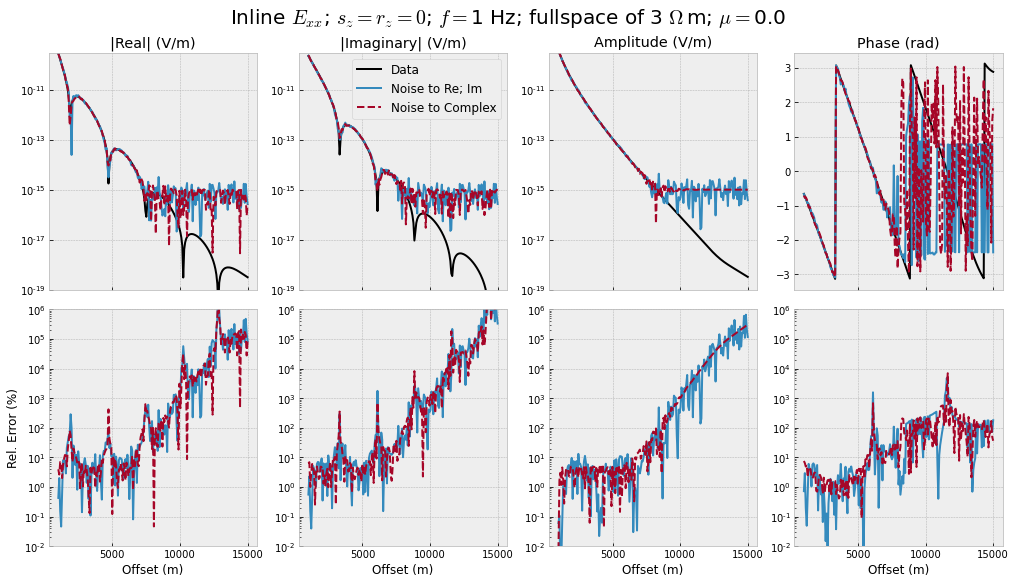

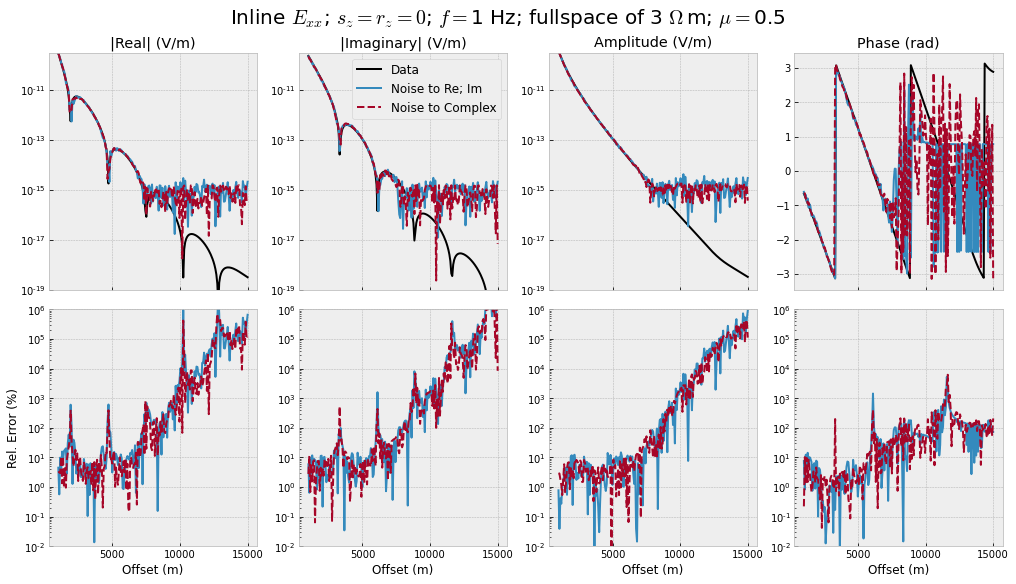

In [5]:
for mu in [0.0, 0.5]:
    # Add noise
    onoise_reim = add_noise(oresp, 'reim', mu=mu)
    onoise_comp = add_noise(oresp, 'phase', mu=mu)

    fig, axs = figure(offs, oresp, onoise_reim, onoise_comp)
    fig.suptitle(f"Inline $E_{{xx}}$; $s_z=r_z=0$; $f=${freq} Hz; "
                 f"fullspace of {model['res']} $\Omega\,$m; $\mu=${mu}", fontsize=20)

    for i in range(3):
        axs[0, i].set_ylim([1e-19, 3e-10])

    for i in range(4):
        axs[1, i].set_xlabel('Offset (m)')
        axs[1, i].set_yscale('log')
        axs[1, i].set_ylim([1e-2, 1e6])

#     fig.savefig(f"/home/dtr/Desktop/offs_{mu}.png", dpi=300, facecolor='w')

# 1.b Offset-range for single frequency - stacked $n$ times

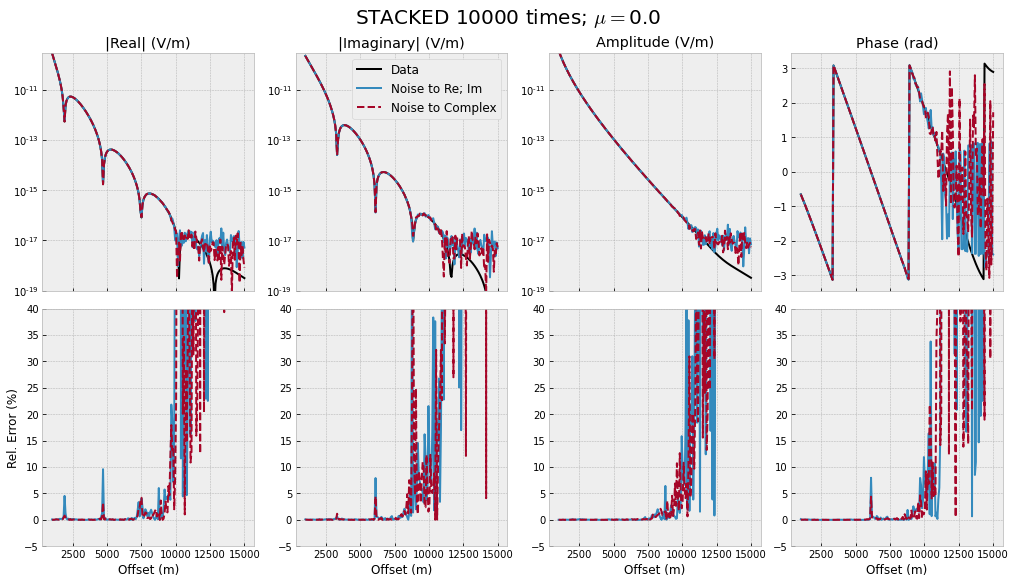

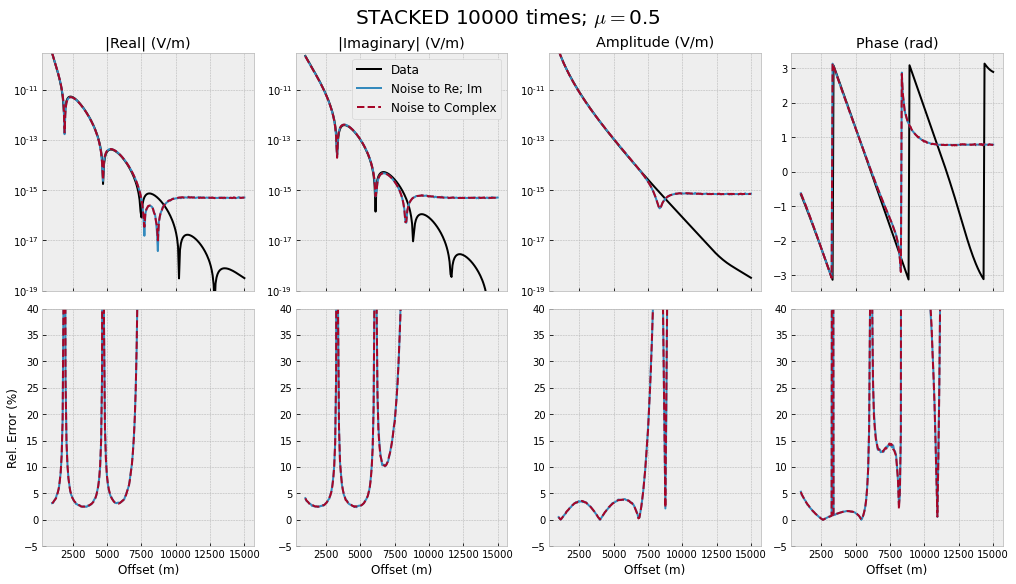

In [6]:
for mu in [0.0, 0.5]:
    # Stack noise
    sonoise_reim = stack(n_stack, oresp, 'reim', mu=mu)
    sonoise_comp = stack(n_stack, oresp, 'phase', mu=mu)

    fig, axs = figure(offs, oresp, sonoise_reim, sonoise_comp)
    fig.suptitle(f"STACKED {n_stack} times; $\mu=${mu}", fontsize=20)

    for i in range(3):
        axs[0, i].set_ylim([1e-19, 3e-10])

    for i in range(4):
        axs[1, i].set_xlabel('Offset (m)')
        axs[1, i].set_ylim([-5, 40])

#     fig.savefig(f"/home/dtr/Desktop/offs_{mu}_stacked.png", dpi=300, facecolor='w')

# 2.a Frequency-range for single offset

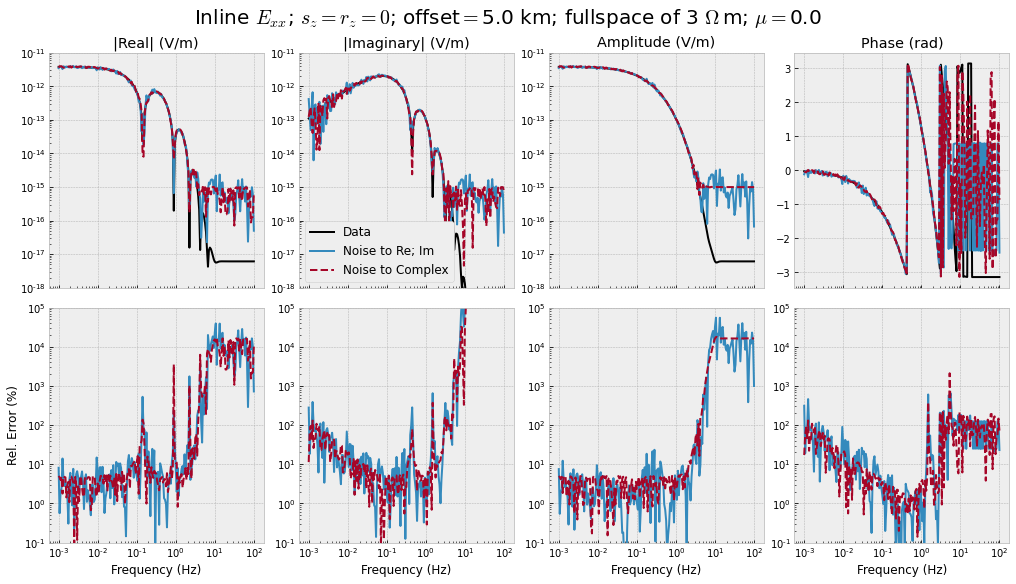

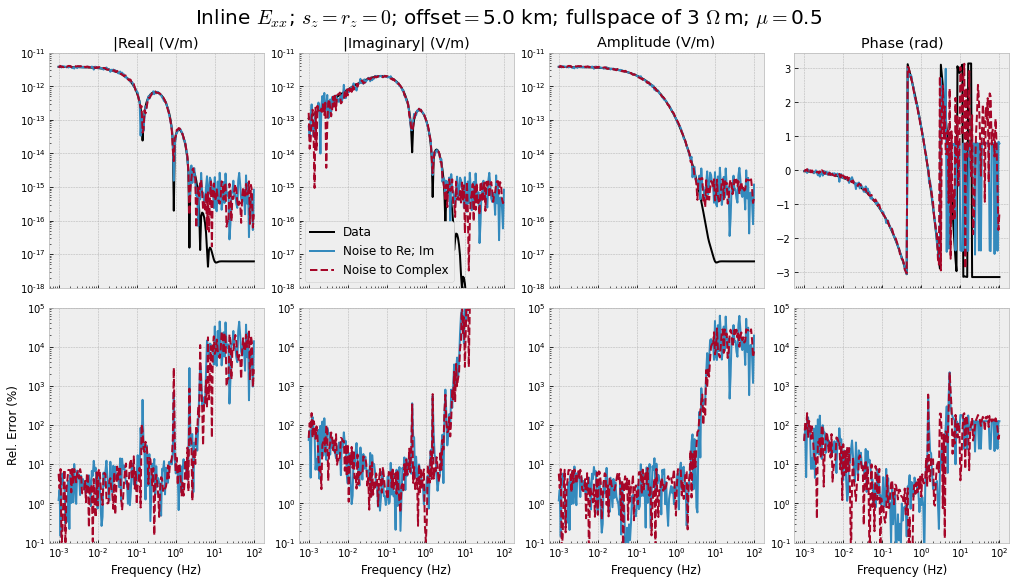

In [7]:
for mu in [0.0, 0.5]:
    # Add noise
    fnoise_reim = add_noise(fresp, 'reim', mu=mu)
    fnoise_comp = add_noise(fresp, 'phase', mu=mu)

    fig, axs = figure(freqs, fresp, fnoise_reim, fnoise_comp)
    fig.suptitle(f"Inline $E_{{xx}}$; $s_z=r_z=0$; offset$=${off/1e3} km; "
                 f"fullspace of {model['res']} $\Omega\,$m; $\mu=${mu}", fontsize=20)

    for i in range(3):
        axs[0, i].set_ylim([1e-18, 1e-11])

    for i in range(4):
        axs[0, i].set_xscale('log')
        axs[1, i].set_xlabel('Frequency (Hz)')
        axs[1, i].set_yscale('log')
        axs[1, i].set_ylim([1e-1, 1e5])    

#     fig.savefig(f"/home/dtr/Desktop/freqs_{mu}.png", dpi=300, facecolor='w')

# 2.b Frequency-range for single offset - stacked $n$ times

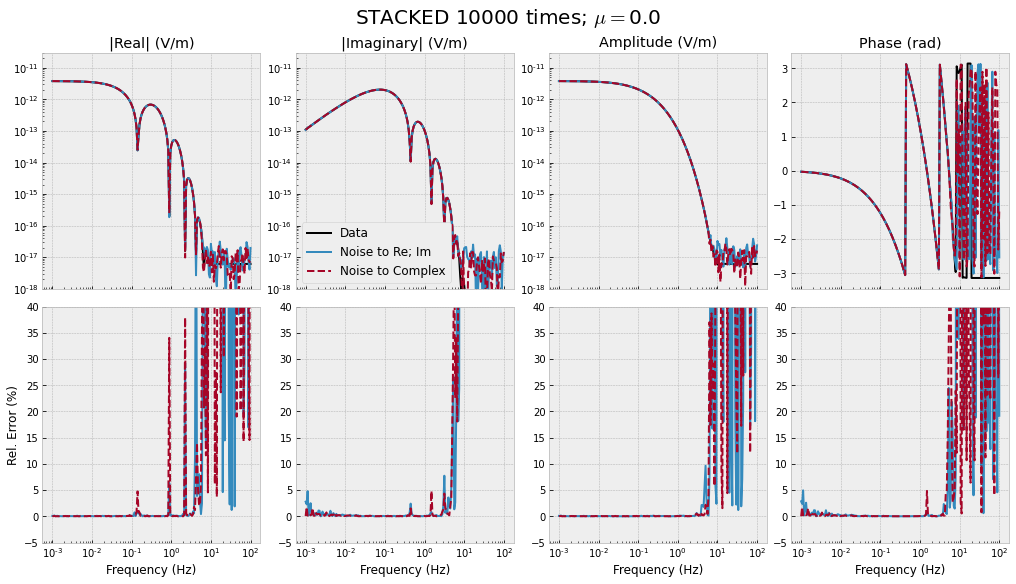

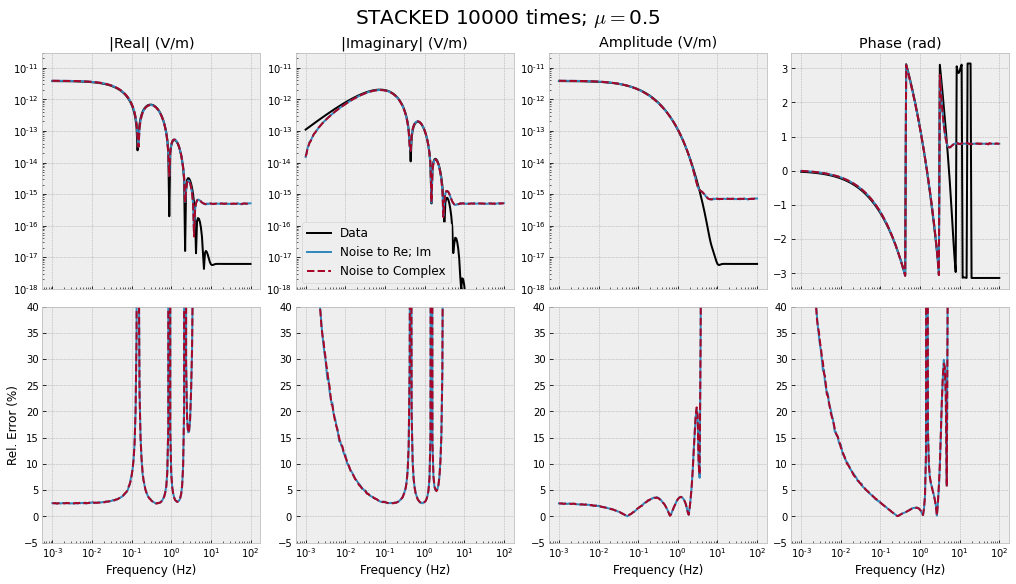

In [8]:
for mu in [0.0, 0.5]:
    # Stack noise
    sfnoise_reim = stack(n_stack, fresp, 'reim', mu=mu)
    sfnoise_comp = stack(n_stack, fresp, 'phase', mu=mu)

    fig, axs = figure(freqs, fresp, sfnoise_reim, sfnoise_comp)
    fig.suptitle(f"STACKED {n_stack} times; $\mu=${mu}", fontsize=20)

    for i in range(3):
        axs[0, i].set_ylim([1e-18, 3e-11])

    for i in range(4):
        axs[0, i].set_xscale('log')
        axs[1, i].set_xlabel('Frequency (Hz)')
        axs[1, i].set_ylim([-5, 40])

#     fig.savefig(f"/home/dtr/Desktop/freqs_{mu}_stacked.png", dpi=300, facecolor='w')

## Graphical illustration

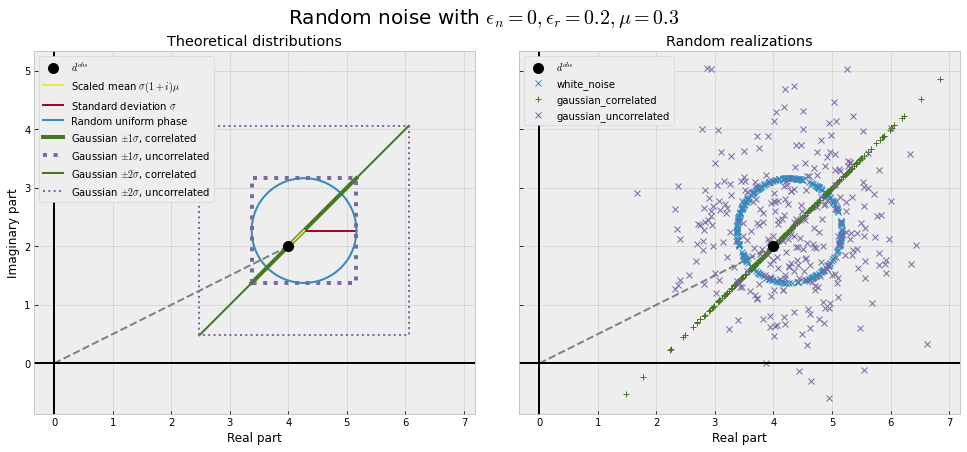

In [9]:
import emg3d
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')


# Inputs
d = np.array([4+2j])         # observed data
mean = 0.3                   # (high) non-zero mean
relative_error = 0.2         # (high) relative error
std = relative_error*abs(d)  # std (without noise floor)

# Calculate theoretical circle
uniform_mean = std * ((1+1j)*mean + np.exp(1j*np.linspace(0, 2*np.pi, 301)))

# Calculate random examples
data = np.ones(300, dtype=complex)*d
stdata = relative_error*abs(data)

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
ax1, ax2 = axs

# Titles
fig.suptitle(f"Random noise with $\epsilon_n = 0, \epsilon_r={relative_error}, "
             f"\mu={mean}$", y=1, fontsize=20)
ax1.set_title('Theoretical distributions')
ax2.set_title('Random realizations')

# Plot data point
for ax in axs:
    ax.plot(np.r_[0., d.real], np.r_[0., d.imag], '--', c='.5')
    ax.plot(d.real, d.imag, 'ko', ms=10, label='$d^{obs}$', zorder=10)
    
# Mean and standard deviation
ax1.plot(d.real+np.r_[0, std*mean], d.imag+np.r_[0, std*mean],
         'C8', label='Scaled mean $\sigma (1+i)\mu$', zorder=9)
ax1.plot(d.real+np.r_[std*mean, std*(1+mean)], d.imag+np.r_[std*mean, std*mean],
         'C1', label=f'Standard deviation $\sigma$')

# Random uniform phase
ax1.plot(d.real+uniform_mean.real, d.imag+uniform_mean.imag, 'C0', label='Random uniform phase')


# Gaussian
for i in range(1, 3):
    # Correlated
    ax1.plot(d.real + np.r_[-std, +std]*i + std*mean,
             d.imag + np.r_[-std, +std]*i + std*mean,
             'C3-', lw=6-2*i, label=f'Gaussian $\pm {i} \sigma$, correlated')

    # Uncorrelated
    ax1.plot(d.real + np.r_[-std, -std, +std, +std, -std]*i + std*mean,
             d.imag + np.r_[-std, +std, +std, -std, -std]*i + std*mean,
             'C2:', lw=6-2*i, label=f'Gaussian $\pm {i} \sigma$, uncorrelated')

# Plot random realizations
ls = ['C0x', 'C3+', 'C2x']
for i, method in enumerate(['white_noise', 'gaussian_correlated', 'gaussian_uncorrelated']):
    ndata = data + emg3d.surveys.random_noise(stdata, mean, method)
    ax2.plot(ndata.real, ndata.imag, ls[i], label=method)

# Axis etc
for ax in axs:
    ax.axhline(c='k')
    ax.axvline(c='k')
    ax.legend(framealpha=1, loc='upper left')
    ax.set_aspect('equal')
    ax.set_xlabel('Real part')
ax1.set_ylabel('Imaginary part')
 
fig.tight_layout()
#fig.savefig(f"/home/dtr/Desktop/random_noise.png", dpi=300, bbox_inches='tight', facecolor='w')

In [10]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Mon Jul 26 21:38:41 2021 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter

  Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27)
  [GCC 9.3.0]

             numpy : 1.20.2
             scipy : 1.7.0
             numba : 0.53.0
           empymod : 2.1.2
           IPython : 7.23.1
        matplotlib : 3.4.2

  Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------